# Collaborative Filtering in Tensorflow

## Set Up Environment

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install and import packages
import os
import random
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.layers import Add, Activation, Lambda, Embedding
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings('ignore')
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Mon Jan  9 22:34:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|      

In [ ]:
# Reproducibility in TF 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['AmazonReviews_RecSysDL'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/AmazonReviews/Data/

/content/drive/MyDrive/AmazonReviews/Data


In [ ]:
# Read data
df = pd.read_csv('Movies_and_TV.csv', header=None, skiprows=[0],
                 low_memory=False)
df = df.drop_duplicates()

# Name columns
df.columns = ['itemID', 'reviewerID', 'rating', 'timestamp']

print('Sample observations:')
df.head()

Sample observations:


,itemID,reviewerID,rating,timestamp
0,0001527665,A2VHSG6TZHU1OB,5.0,1361145600
1,0001527665,A23EJWOW1TLENE,5.0,1358380800
2,0001527665,A1KM9FNEJ8Q171,5.0,1357776000
3,0001527665,A38LY2SSHVHRYB,4.0,1356480000
4,0001527665,AHTYUW2H1276L,5.0,1353024000


In [ ]:
# Data summary
def data_summary(df):
    print('Number of Rows: {}, Columns: {}'.format(df.shape[0], df.shape[1]))
    a = pd.DataFrame()
    a['Number of Unique Values'] = df.nunique()
    a['Number of Missing Values'] = df.isnull().sum()
    a['Data type of variable'] = df.dtypes
    print(a)

print('\nData Summary')     
print(data_summary(df))

df = df.drop(['timestamp'], axis=1)


Data Summary
Number of Rows: 8522125, Columns: 5
            Number of Unique Values  Number of Missing Values  \
itemID                       182032                         0   
reviewerID                  3826085                         0   
rating                            5                         0   
timestamp                      7476                         0   
item                         182032                         0   

           Data type of variable  
itemID                    object  
reviewerID                object  
rating                   float64  
timestamp                  int64  
item                       int64  
None


In [ ]:
# Filter to reviewers with >= 25 reviews
reviewer_count = df.reviewerID.value_counts()
df = df[df.reviewerID.isin(reviewer_count[reviewer_count >= 25].index)]
df = df.drop_duplicates()

del reviewer_count

print('- Number of ratings after filtering: ', len(df))
print('- Number of unique reviewers: ', df['reviewerID'].nunique())
print('- Number of unique items: ', df['itemID'].nunique())
for i in range(1,6):
  print('- Number of items with {0} rating = {1}'.format(i, df[df['rating'] == i].shape[0]))

- Number of ratings after filtering:  1114877
- Number of unique reviewers:  19702
- Number of unique items:  103731
- Number of items with 1 rating = 59576
- Number of items with 2 rating = 65630
- Number of items with 3 rating = 141579
- Number of items with 4 rating = 252845
- Number of items with 5 rating = 595247


In [ ]:
# Find most frequent rated item
df.groupby('itemID')['rating'].count().sort_values(ascending=False).head()

itemID
B009934S5M    1136
B00PY4Q9OS    1042
B00R8GUXPG    1040
B00Q0G2VXM    1040
B00NYC65M8     965
Name: rating, dtype: int64

In [ ]:
# Label encode user
user_encode = LabelEncoder()
df['user'] = user_encode.fit_transform(df['reviewerID'].values)
n_users = df['user'].nunique()

In [ ]:
# Label encode items
item_encode = LabelEncoder()
df['item'] = item_encode.fit_transform(df['itemID'].values)
n_items = df['item'].nunique()

In [ ]:
# Create min/max rating variable
df['stars'] = df['rating'].values

min_rating = min(df['stars'])
max_rating = max(df['stars'])

print('Number of unique items:', n_items)
print('Number of unique users:', n_users)
print('Minimum rating:', min_rating)
print('Maximum rating:', max_rating)

# Set number of factors
n_factors = 50

Number of unique items: 103731
Number of unique users: 19702
Minimum rating: 1.0
Maximum rating: 5.0


In [ ]:
# Set up train/test sets
X = df[['user', 'item']].values
y = df['stars'].values

del df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                     random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

del X, y

print('Train data split:', len(X_train))
print('Eval data split:', len(X_test))

# Create arrays
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Train data split: 891901
Eval data split: 222976


In [ ]:
# Set path for results
%cd /content/drive/MyDrive/AmazonReviews/DL/Models/

/content/drive/MyDrive/AmazonReviews/DL/Models


## Define Model Architecture

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, 
                      embeddings_initializer='he_normal', 
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x

In [ ]:
def Recommender(n_users, n_items, n_factors, min_rating, max_rating):
    
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    Item = Input(shape=(1,))
    m = EmbeddingLayer(n_items, n_factors)(Item)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)    
    model = Model(inputs=[user, Item], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [ ]:
# Model summary
keras_model = Recommender(n_users, n_items, n_factors, min_rating, max_rating)
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        985100      ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        5186550     ['input_3[0][0]']                
                                                                                              

## Batch Size = 16

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'CF_Baseline_b16_dropout0.2_weights_only.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_loss', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit model
history = keras_model.fit(x=X_train_array, y=y_train, 
                          validation_data=(X_test_array, y_test), 
                          batch_size=16, epochs=10, callbacks=callbacks_list)

Epoch 1/10
55744/55744 [==============================] - 289s 5ms/step - loss: 1.0271 - val_loss: 0.9597
Epoch 2/10
55744/55744 [==============================] - 291s 5ms/step - loss: 0.9599 - val_loss: 0.9527
Epoch 3/10
55744/55744 [==============================] - 281s 5ms/step - loss: 0.9551 - val_loss: 0.9528
Epoch 4/10
55744/55744 [==============================] - 281s 5ms/step - loss: 0.9517 - val_loss: 0.9474
Epoch 5/10
55744/55744 [==============================] - 279s 5ms/step - loss: 0.9516 - val_loss: 0.9447
Epoch 6/10
55744/55744 [==============================] - 277s 5ms/step - loss: 0.9535 - val_loss: 0.9471
Epoch 7/10
55744/55744 [==============================] - 277s 5ms/step - loss: 0.9508 - val_loss: 0.9534
Epoch 8/10
55744/55744 [==============================] - 277s 5ms/step - loss: 0.9506 - val_loss: 0.9445
Epoch 9/10
55744/55744 [==============================] - 275s 5ms/step - loss: 0.9485 - val_loss: 0.9482
Epoch 10/10
55744/55744 [=====================

In [ ]:
# Save model
keras_model.save('./baselineCF_Model2_batch16_dropout0.2_tf.h5', 
                 save_format='tf')

# Load model for more training or later use
#filepath = 'CF_Baseline_b16_dropout0.2_weights_only.h5'
#model = tf.keras.models.load_model('./baselineCF_Model2_batch16_dropout0.2_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

In [ ]:
# Predict on test set
predictions = keras_model.predict(X_test_array)

6968/6968 [==============================] - 9s 1ms/step


In [ ]:
# Create table with prediction results
df_test = pd.DataFrame(X_test[:,0])
df_test.rename(columns={0: 'user'}, inplace=True)
df_test['items'] = X_test[:,1]
df_test['stars'] = y_test
df_test['predictions'] = predictions
df_test.head()

,user,items,stars,predictions
0,14701,17937,3.0,1.903274
1,17387,97250,5.0,3.822067
2,17411,66343,4.0,4.709871
3,6792,10159,5.0,3.698924
4,2965,77733,5.0,4.655035


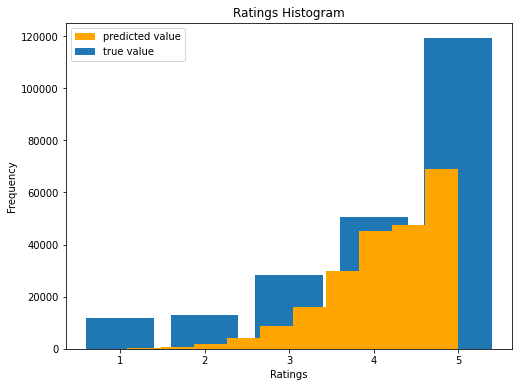

In [ ]:
# Plot the distribution of actual and predicted stars
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Histogram')
plt.legend()
plt.savefig('TF_cfBaseline_Model2_b16_dropout0.2_MoviesTV_actualPredictedRatings.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

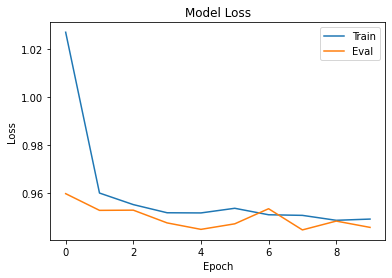

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_CF_baseline_Model2_filtered_batch16_dropout0.2_Loss.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Extract embeddings
emb = keras_model.get_layer('embedding_1')
emb_weights = emb.get_weights()[0]

print('The shape of embedded weights: ', emb_weights.shape)
print('The length of embedded weights: ', len(emb_weights))

The shape of embedded weights:  (103731, 50)
The length of embedded weights:  103731


<a id="cos-similarity"></a>
### Cosine similarity

Each item is now represented as a 50-dimensional vector. The embeddings need to normalized so the dot product between two embeddings is the cosine similarity. The Cosine Similarity calculates a numeric value that represents the similarity between two items. The embedding layers from the model are needed to compute the cosine similarity via a dot product.

In [ ]:
# Normalize and reshape embedded weights
emb_weights = emb_weights / np.linalg.norm(emb_weights, axis=1).reshape((-1, 1))
len(emb_weights)

103731

In [ ]:
# Find all unique items
rest_id_emb = df['itemID'].unique()
len(rest_id_emb)

103731

Create a table containing all the unique items in 50 dimensions with their embedded weights.

In [ ]:
rest_pd = pd.DataFrame(emb_weights)
rest_pd['itemID'] = rest_id_emb
rest_pd = rest_pd.set_index('itemID')
rest_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
itemID,,,,,,,,,,,,,,,,,,,,,
000503860X,inf,-inf,-inf,inf,-inf,-inf,-inf,inf,-inf,-inf,...,inf,inf,-inf,inf,inf,inf,inf,-inf,inf,-inf
0005092663,inf,-inf,inf,inf,inf,inf,inf,-inf,inf,inf,...,-inf,inf,-inf,-inf,-inf,-inf,-inf,inf,inf,inf
0005019281,-inf,-inf,inf,inf,-inf,inf,-inf,inf,inf,inf,...,-inf,-inf,-inf,inf,-inf,inf,-inf,-inf,-inf,-inf
0005119367,-0.141163,1.477967e-01,2.316365e-29,0.147855,-0.147876,1.178349e-01,0.082837,1.471831e-01,-1.494529e-01,1.230121e-01,...,-1.486145e-01,1.413215e-01,1.493893e-01,-0.149376,2.305986e-29,-0.147192,1.488855e-01,-0.149351,-1.472584e-01,0.150208
0005123968,inf,-inf,-inf,-inf,inf,-inf,-inf,inf,inf,inf,...,inf,inf,-inf,-inf,-inf,-inf,inf,-inf,-inf,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HHZKOG0,-0.008267,-2.236083e-01,-2.599621e-02,-0.223686,-0.144924,2.091652e-01,-0.120053,-1.055703e-01,2.093079e-01,-1.650761e-01,...,5.156517e-02,-2.127886e-01,8.212486e-03,-0.005607,-2.685340e-02,-0.015225,-1.140203e-02,0.216453,5.390420e-02,-0.241080
B01HI8KC5E,0.000015,-1.177827e-28,1.772185e-08,-0.006270,0.011387,-1.183634e-28,-0.001693,1.198261e-28,1.190786e-28,-1.198461e-28,...,1.178250e-28,-5.411250e-14,6.627290e-07,0.000355,1.078850e-03,-0.000003,-5.405612e-09,0.000071,1.029599e-18,-0.001684
B01HI87P4K,-0.192161,9.981440e-04,-1.826643e-01,-0.178949,0.162945,1.688821e-01,-0.000266,-1.660917e-01,1.671402e-01,1.536722e-01,...,1.100356e-01,-1.763748e-01,3.756321e-02,-0.114001,-1.473959e-02,-0.120297,1.098178e-01,0.197131,1.383827e-01,-0.150529


In [ ]:
# Merge rest_pd and temp tables to get the items
temp = df[['itemID']].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on='itemID')

# Copy column
df_recommend['item'] = df_recommend.loc[:, 'itemID']

# Remove inf from data
df_recommend = df_recommend[~df_recommend.isin([np.nan, np.inf, -np.inf]).any(1)]
df_recommend.shape

(63771, 52)

<a id="recommendation"></a>
### Recommendation

Use the model to recommend items that should be suggested to be purchased with the most rated items

In [ ]:
# Extract the most frequent item from the df_recommend table
target = df_recommend[df_recommend['itemID'] == 'B009934S5M']
target.iloc[:,1:51]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
37053,-1.156681e-09,-1.606160e-08,-2.588017e-13,-9.729131e-08,-2.200199e-08,7.366057e-17,-1.738605e-08,-5.099906e-29,1.917073e-12,0.000001,...,-5.499675e-09,2.029545e-07,-8.241665e-08,1.076832e-13,1.749618e-10,-1.007077e-11,1.244030e-09,0.000003,-1.965046e-08,-0.000169


Calculate the cosine similarity between the target and the rest of the other items storing the result in a table.

In [ ]:
def find_similarity_total(item_name):

    """ Recommends item based on the cosine similarity between items """

    cosine_list_total = []
    result = []

    for i in range(0, df_recommend.shape[0]):
        sample_name = df_recommend[df_recommend['item'] == item_name].iloc[:,1:51]
        row = df_recommend.iloc[i,1:51]
        cosine_total = np.dot(sample_name, row)
        
        recommended_name = df_recommend.iloc[i,51]
        cosine_list_total.append(cosine_total)
        result.append(recommended_name)
        
    cosine_df_total = pd.DataFrame({'similar_item': result, 
                                    'cosine': cosine_list_total})

    return cosine_df_total

In [ ]:
# Call the function with input of most frequent item 
result = find_similarity_total('B009934S5M')

In [ ]:
def convert(input):
  
  """ Replace '[]' to empty strings & Convert string to float """
  
    return float(str(input).replace('[','').replace(']',''))

In [ ]:
# Create new column called "cos" in result table
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)

# Drop original 'cosine' column (which had values with np.array)
result.drop('cosine', axis=1, inplace=True)

# Sort values
result = result.sort_values('cos', ascending=False)
result.to_csv('TF_CF_baseline_b16_dropout0.2_cosSimMostFrequentItem.csv')
result.head(10)

,similar_item,cos
60553,B00KHW4XHM,1.148089
37066,B0000JLLAO,1.115949
30263,B01F6EHOIK,1.112725
16538,B00199PP6U,1.043721
6666,B00005LZOF,1.038528
8372,B00009IAXL,1.018756
38499,B0006FFRKM,1.013303
32816,6304492952,1.005688
23900,B009934S5M,1.000000
42424,B000HT3QBY,0.999978


The model recommends items that should be suggested to be purchased with the most rated item, which was `Star Trek Into Darkness (Blu-ray)` (`B009934S5M`).

- B00KHW4XHM - Criterion Collection: Golden Age of Television 
- B0000JLLAO - Not found
- B01F6EHOIK - Red Sonja: Queen Of Plagues 
- B00199PP6U - Adventures of the Galaxy Rangers Collection Vol. 2 
- B00005LZOF - Not found
- B00009IAXL - Malibooty: Beach with 5:1 ratio females:male
- B0006FFRKM - Stellvia: Foundation III - Anime sold of Amazon Italy	
- 6304492952 - Disney Sing Along Songs - The Early Years, Collection of All-Time Favorites VHS
- B009934S5M - Star Trek Into Darkness (Blu-ray) 
- B000HT3QBY - The Most Beautiful Wife - Italy, mafia, girl punished

In [ ]:
# Call the function with another frequent item as input
result = find_similarity_total('B00PY4Q9OS')
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)
result.drop('cosine', axis=1, inplace=True)
result = result.sort_values('cos', ascending=False)
result.to_csv('TF_CF_baseline_b16_dropout0.2_cosSim_B00PY4Q9OS.csv')
result.head(10)

,similar_item,cos
28219,B00PY4Q9OS,1.000000
9836,B00062IZ2C,0.999615
29467,B0157757NK,0.999062
20906,B004L1DB9G,0.998818
7998,B00008973P,0.998594
34385,B00004I9YP,0.998380
12898,B000H4JH4O,0.997436
57305,B00ABCJQZW,0.997081
41731,B000FJMZ0O,0.997028
6437,B00005JM7T,0.996673


The model recommends items that should be suggested to be purchased with the most second most rated item, which was `Guardians of the Galaxy 3D - Limited Edition Steelbook` (`B00PY4Q9OS`). 

- B00062IZ2C - Star Hunter 01 
- B0157757NK - Fire City: End of Days - Battle over earth w demons
- B004L1DB9G - Born to Fight [Blu-ray] - Train for the biggest boxing match with a bully
- B00008973P - 101 Reykjavík [DVD] - Contemporary Icelandic version of American movies of the 1970s like Five Easy Pieces, in which antiheroic characters struggle 
- B00004I9YP - Not found
- B000H4JH4O - Keeping Up With the Steins [DVD] - Heartwarming coming-of-age comedy when three generations collide in a crazy family reunion
- B00ABCJQZW - Celebrate With Clifford (Clifford The Big Red Dog)  [DVD]
- B000FJMZ0O - Not found
- B00005JM7T - Dr. Seuss' The Cat In The Hat (Widescreen Edition) [DVD]


In [ ]:
# Call the function with another frequent item as input
result = find_similarity_total('B00R8GUXPG')
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)
result.drop('cosine', axis=1, inplace=True)
result = result.sort_values('cos', ascending=False)
result.to_csv('TF_CF_baseline_b16_dropout0.2_cosSim_B00R8GUXPG.csv')
result.head(10)

,similar_item,cos
42262,B000H6SUYK,1.193777
9370,B00023GFUY,1.161545
2121,6303023355,1.151336
20807,B004I1CVV8,1.151042
49743,B001O17SW2,1.141012
47718,B0019BLYUO,1.076888
15472,B000ZBEOGK,1.072506
39396,B0009OUBUG,1.057287
52853,B00443FMK2,1.040808
36531,B00008PW2B,1.035146


Item ID (ASIN) was not able to be found.

## Batch Size = 8

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'CF_Baseline_b8_dropout0.2_weights_only.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_loss', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit model
history = keras_model.fit(x=X_train_array, y=y_train, 
                          validation_data=(X_test_array, y_test), 
                          batch_size=8, epochs=10, callbacks=callbacks_list)

Epoch 1/10
111488/111488 [==============================] - 574s 5ms/step - loss: 1.0626 - val_loss: 1.0098
Epoch 2/10
111488/111488 [==============================] - 571s 5ms/step - loss: 1.0186 - val_loss: 1.0042
Epoch 3/10
111488/111488 [==============================] - 568s 5ms/step - loss: 1.0181 - val_loss: 1.0056
Epoch 4/10
111488/111488 [==============================] - 566s 5ms/step - loss: 1.0196 - val_loss: 1.0078
Epoch 5/10
111488/111488 [==============================] - 565s 5ms/step - loss: 1.0211 - val_loss: 1.0091


In [ ]:
# Save model
keras_model.save('./baselineCF_Model2_batch8_dropout0.2_tf.h5', 
                 save_format='tf')

# Load model for more training or later use
#filepath = 'CF_Baseline_b8_dropout0.2_weights_only.h5'
#model = tf.keras.models.load_model('./baselineCF_Model2_batch8_dropout0.2_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

In [ ]:
# Prdict on test set
predictions = keras_model.predict(X_test_array)

6968/6968 [==============================] - 9s 1ms/step


In [ ]:
# Create table with prediction results
df_test = pd.DataFrame(X_test[:,0])
df_test.rename(columns={0: 'user'}, inplace=True)
df_test['items'] = X_test[:,1]
df_test['stars'] = y_test
df_test['predictions'] = predictions
df_test.head()

,user,items,stars,predictions
0,14701,17937,3.0,2.267012
1,17387,97250,5.0,3.749072
2,17411,66343,4.0,4.731325
3,6792,10159,5.0,3.781336
4,2965,77733,5.0,4.521596


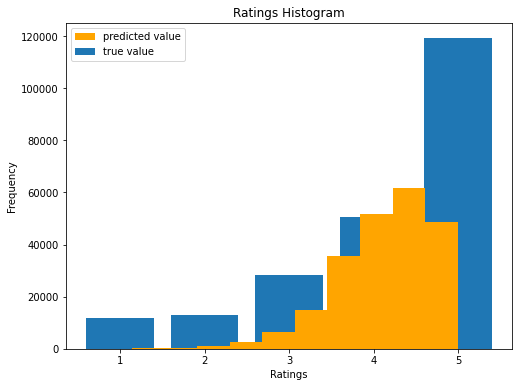

In [ ]:
# Plot the distribution of actual and predicted stars
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Histogram')
plt.legend()
plt.savefig('TF_cfBaseline_Model2_b8_dropout0.2_MoviesTV_actualPredictedRatings.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

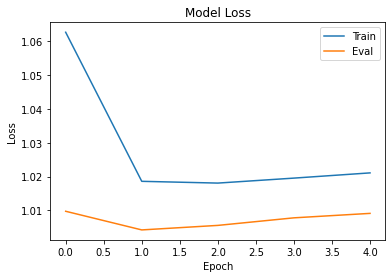

In [ ]:
# Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_CF_baseline_Model2_filtered_batch8_dropout0.2_Loss.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Extract embeddings
emb = keras_model.get_layer('embedding_11')
emb_weights = emb.get_weights()[0]

print('The shape of embedded weights: ', emb_weights.shape)
print('The length of embedded weights: ', len(emb_weights))

The shape of embedded weights:  (103731, 50)
The length of embedded weights:  103731


<a id="cos-similarity"></a>
### Cosine similarity

Each item is now represented as a 50-dimensional vector. The embeddings need to normalized so the dot product between two embeddings is the cosine similarity. The Cosine Similarity calculates a numeric value that represents the similarity between two items. The embedding layers from the model are needed to compute the cosine similarity via a dot product.

In [ ]:
# Normalize and reshape embedded weights
emb_weights = emb_weights / np.linalg.norm(emb_weights, axis=1).reshape((-1, 1))
len(emb_weights)

103731

In [ ]:
# Find all unique item
rest_id_emb = df['itemID'].unique()
len(rest_id_emb)

103731

Create a table with all the unique items in 50 dimensions with their embedded weights.

In [ ]:
rest_pd = pd.DataFrame(emb_weights)
rest_pd['itemID'] = rest_id_emb
rest_pd = rest_pd.set_index('itemID')
rest_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
itemID,,,,,,,,,,,,,,,,,,,,,
000503860X,-inf,-inf,inf,inf,inf,inf,inf,-inf,inf,inf,...,-inf,inf,inf,inf,-inf,inf,inf,-inf,-inf,inf
0005092663,-inf,-inf,inf,-inf,-inf,inf,inf,-inf,inf,inf,...,-inf,inf,inf,-inf,-inf,inf,inf,-inf,-inf,inf
0005019281,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,inf,-inf,...,inf,-inf,-inf,-inf,inf,-inf,-inf,-inf,inf,-inf
0005119367,-1.090690e-28,1.731628e-10,-1.086338e-28,1.232361e-10,-0.116705,-0.153975,-2.389029e-04,-5.150603e-02,0.013055,3.204659e-04,...,0.000140,-1.095652e-28,-7.075178e-03,5.015315e-03,2.480933e-04,-4.935525e-12,0.013148,0.010717,-0.000146,0.107412
0005123968,-inf,-inf,-inf,inf,inf,-inf,inf,-inf,-inf,inf,...,inf,-inf,inf,-inf,-inf,inf,inf,-inf,-inf,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HHZKOG0,-3.712402e-08,-4.029023e-03,4.909287e-09,-1.923616e-07,-0.003230,-0.002738,2.696407e-07,3.736180e-07,-0.000176,-2.457352e-09,...,0.000092,4.232260e-04,-2.973162e-07,3.344762e-19,-6.953103e-08,3.354215e-11,-0.000318,0.000018,0.002259,0.000222
B01HI8KC5E,-inf,inf,inf,inf,inf,-inf,-inf,-inf,inf,inf,...,inf,-inf,-inf,inf,inf,inf,inf,inf,-inf,inf
B01HI87P4K,1.339735e-01,-1.418108e-01,8.517871e-03,-1.393756e-01,-0.141205,-0.142142,1.445967e-01,-1.346857e-01,-0.141986,-1.300971e-01,...,0.141561,-1.383641e-01,-1.366770e-01,1.268713e-01,-1.408127e-01,1.414165e-01,-0.137534,0.140210,0.141345,0.103656


In [ ]:
# Merge rest_pd and temp tables to get the items
temp = df[['itemID']].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on='itemID')
df_recommend

# Copy column
df_recommend['item'] = df_recommend.loc[:, 'itemID']

# Remove inf from data
df_recommend = df_recommend[~df_recommend.isin([np.nan, np.inf, -np.inf]).any(1)]
df_recommend.shape

(47155, 52)

<a id="recommendation"></a>
### Recommendation

Use the model to recommend items that should be suggested to be purchased with the most rated items.

In [ ]:
# Extract the most frequent item from the df_recommend table
target = df_recommend[df_recommend['itemID'] == 'B009934S5M']
target.iloc[:,1:51]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
37053,0.179735,-0.0002,0.019605,0.12197,0.116619,-0.141715,-0.180107,0.133885,-0.006806,-0.154242,...,0.068756,-0.262161,-0.122876,-0.04213,0.159202,-0.200544,0.097041,-0.148478,0.141077,0.004964


In [ ]:
# Call the function with input of most frequent item 
result = find_similarity_total('B009934S5M')

# Create new column called "cos" in result table
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)

# Drop original 'cosine' column (which had values with np.array)
result.drop('cosine', axis=1, inplace=True)

# Sort values
result = result.sort_values('cos', ascending=False)
result.to_csv('TF_CF_baseline_b8_dropout0.2_cosSimMostFrequentItem.csv')
result.head(10)

,similar_item,cos
18010,B009934S5M,1.000000
5555,B00005U8QD,0.872185
11124,B000P5FH5I,0.828417
13565,B001JAHSIM,0.816748
33908,B000WYVUZS,0.805130
37096,B001TXVSPS,0.789085
17658,B007OCD1CG,0.788496
32716,B000OZ2CTS,0.782737
44674,B00JWS9IS6,0.780625
11750,B000W8KY0G,0.767757


The model recommends items that should be suggested to be purchased with the most rated item, which was `Star Trek Into Darkness (Blu-ray)` (`B009934S5M`).

- B009934S5M - Star Trek Into Darkness (Blu-ray) 
- B00005U8QD 	- Witchouse 3: Demon Fire (Widescreen Special Edition) 
- B000P5FH5I 	- Dora The Explorer - Summer Explorer 
- B001JAHSIM 	- Not found
- B000WYVUZS 	- Not found
- B001TXVSPS 	- Not found
- B007OCD1CG 	- Simply Red: Live at Montreux 2003 [Blu-ray]  music
- B000OZ2CTS 	- Vandread and Vandread the Second Stage: Complete Collection  anime
- B00JWS9IS6 	- President Wolfman [Edizione: Stati Uniti] [Edizione: USA] 
- B000W8KY0G 	- Not found


## Batch Size = 4

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'CF_Baseline_b4_dropout0.2_weights_only.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_loss', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit model
history = keras_model.fit(x=X_train_array, y=y_train, 
                          validation_data=(X_test_array, y_test), 
                          batch_size=4, epochs=10, callbacks=callbacks_list)

Epoch 1/10
222976/222976 [==============================] - 1161s 5ms/step - loss: 1.0766 - val_loss: 1.0764
Epoch 2/10
222976/222976 [==============================] - 1156s 5ms/step - loss: 1.0933 - val_loss: 1.0816
Epoch 3/10
222976/222976 [==============================] - 1151s 5ms/step - loss: 1.0951 - val_loss: 1.0792
Epoch 4/10
222976/222976 [==============================] - 1150s 5ms/step - loss: 1.0934 - val_loss: 1.0757
Epoch 5/10
222976/222976 [==============================] - 1145s 5ms/step - loss: 1.0959 - val_loss: 1.0833
Epoch 6/10
222976/222976 [==============================] - 1150s 5ms/step - loss: 1.0960 - val_loss: 1.0764
Epoch 7/10
222976/222976 [==============================] - 1148s 5ms/step - loss: 1.0934 - val_loss: 1.0762


In [ ]:
# Save model
keras_model.save('./baselineCF_Model2_batch4_dropout0.2_tf.h5', 
                 save_format='tf')

# Load model for more training or later use
#filepath = 'CF_Baseline_b4_dropout0.2_weights_only.h5'
#model = tf.keras.models.load_model('./baselineCF_Model2_batch4_dropout0.2_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

In [ ]:
# Predict on the test set
predictions = keras_model.predict(X_test_array)

6968/6968 [==============================] - 9s 1ms/step


In [ ]:
# Create table with prediction results
df_test = pd.DataFrame(X_test[:,0])
df_test.rename(columns={0: 'user'}, inplace=True)
df_test['items'] = X_test[:,1]
df_test['stars'] = y_test
df_test['predictions'] = predictions
df_test.head()

,user,items,stars,predictions
0,14701,17937,3.0,3.044298
1,17387,97250,5.0,4.028919
2,17411,66343,4.0,4.670388
3,6792,10159,5.0,3.646271
4,2965,77733,5.0,4.846884


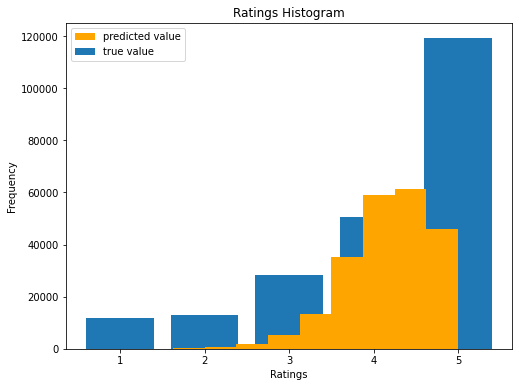

In [ ]:
# Plot the distribution of actual and predicted stars
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Histogram')
plt.legend()
plt.savefig('TF_cfBaseline_Model2_b4_dropout0.2_MoviesTV_actualPredictedRatings.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

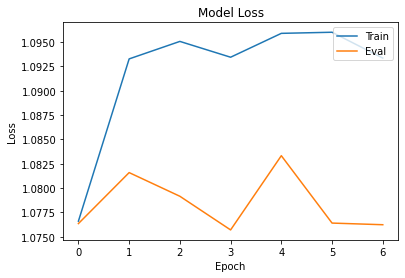

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_CF_baseline_Model2_filtered_batch4_dropout0.2_Loss.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Extract embeddings
emb = keras_model.get_layer('embedding_1')
emb_weights = emb.get_weights()[0]

print('The shape of embedded weights: ', emb_weights.shape)
print('The length of embedded weights: ', len(emb_weights))

The shape of embedded weights:  (103731, 50)
The length of embedded weights:  103731


<a id="cos-similarity"></a>
### Cosine similarity

Each item is now represented as a 50-dimensional vector. The embeddings need to normalized so the dot product between two embeddings is the cosine similarity. The Cosine Similarity calculates a numeric value that represents the similarity between two items. The embedding layers from the model are needed to compute the cosine similarity via a dot product.

In [ ]:
# Normalize and reshape embedded weights
emb_weights = emb_weights / np.linalg.norm(emb_weights, axis=1).reshape((-1, 1))
len(emb_weights)

103731

In [ ]:
# Find all unique items
rest_id_emb = df['itemID'].unique()
len(rest_id_emb)

103731

Create a table with all the unique items in 50 dimensions with their embedded weights.

In [ ]:
rest_pd = pd.DataFrame(emb_weights)
rest_pd['itemID'] = rest_id_emb
rest_pd = rest_pd.set_index('itemID')
rest_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
itemID,,,,,,,,,,,,,,,,,,,,,
000503860X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005092663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005019281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005119367,-1.213355e-22,1.209924e-22,1.194500e-22,-1.209824e-22,1.192818e-22,-1.198307e-22,-1.324492e-16,1.204987e-22,1.194996e-22,1.210271e-22,...,1.202204e-22,1.208744e-22,-1.192897e-22,1.206772e-22,-1.206811e-22,1.207339e-22,-1.205677e-22,1.173929e-22,2.534581e-22,3.027364e-22
0005123968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HHZKOG0,5.335892e-21,3.352514e-12,8.420437e-06,-6.970930e-15,-3.940534e-16,-2.258153e-05,-3.488777e-14,1.286175e-08,-2.835066e-24,3.601613e-10,...,-3.007164e-11,-6.445539e-28,-4.474471e-27,6.214222e-08,8.282424e-08,-9.794673e-05,-5.745024e-18,6.484021e-28,-2.704632e-18,-4.022194e-08
B01HI8KC5E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B01HI87P4K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merge rest_pd and temp tables to get the items
temp = df[['itemID']].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on='itemID')

# Copy column
df_recommend['item'] = df_recommend.loc[:, 'itemID']

# Remove inf from data
df_recommend = df_recommend[~df_recommend.isin([np.nan, np.inf, -np.inf]).any(1)]
df_recommend.shape

(33537, 52)

<a id="recommendation"></a>
### Recommendation

Use the model to recommend items that should be suggested to be purchased with the most rated items.

In [ ]:
# Extract the most frequent item from the df_recommend table
target = df_recommend[df_recommend['itemID'] == 'B009934S5M']
target.iloc[:,1:51]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
37053,-0.160317,0.121403,-0.151604,0.052381,0.080456,0.188435,0.087339,0.074445,4.216525e-29,-0.15207,...,0.009734,-0.217215,-2.965897e-15,0.149945,0.150367,0.155603,0.011443,-0.160506,-0.192411,0.066785


In [ ]:
# call the function with input of most frequent item and store it in result variable.
result = find_similarity_total('B009934S5M')

In [ ]:
# create new column called "cos" in result table
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)

# drop original 'cosine' column (which had values with np.array)
result.drop('cosine', axis=1, inplace=True)

# sort values with cos
result = result.sort_values('cos', ascending=False)
result.to_csv('TF_CF_baseline_b32_dropout0.2_cosSimMostFrequentItem.csv')
result.head(10)

,similar_item,cos
13097,B009934S5M,1.000000
24196,B00006FD8Z,0.903208
18521,B00005LPZR,0.899426
2330,6304432437,0.894572
24083,B000WM4R1Y,0.890307
9980,B001HUWQGS,0.877146
19598,B00011ZBQ6,0.868980
24632,B00136W7E2,0.866152
24790,B00150Z9QY,0.851939
10942,B002Y58G7S,0.846271


Use the model to recommend items that should be suggested to be purchased with the most second most rated item, which was `Guardians of the Galaxy 3D - Limited Edition Steelbook` (`B00PY4Q9OS`). 

- B00006FD8Z 	- Ex-Driver: Vol. 2 - Crossroads [DVD] - Anime
- B00005LPZR 	- Sumo Vixens [DVD] - Asian Pulp Cinema
- 6304432437 	- Doctor Who: Paradise Towers [Edizione: USA] 
- B000WM4R1Y 	- Dark Mind - Mystery & Thrillers
- B001HUWQGS 	- Curse of the Pink Panther 
- B00011ZBQ6 	- Vol. 7-Gods of War - Anime
- B00136W7E2 	- Crazy Like a Fox [DVD] - Tale about family and the determination
- B00150Z9QY 	- Hollywood Dreams - Goal of becoming actress
- B002Y58G7S 	- The Brothers Warner - Documentary